<a href="https://colab.research.google.com/github/nnilayy/Unet/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab.patches import cv2_imshow
img=read_image("/content/Images/1.jpeg")
cv2_imshow(img*255)
img.shape

## Image Preprocessing

In [ ]:
import cv2
import glob 
import numpy as np
X_train=[]
y_train=[]
images=sorted(glob.glob("/content/drive/MyDrive/Augmented/Images/*"))
masks=sorted(glob.glob("/content/drive/MyDrive/Augmented/Masks/*"))


for image,mask in zip(images,masks):
  img=cv2.imread(image)
  img=np.array(img)
  img=np.resize(img,(1,256,256,3))
  X_train.append(img)
 
  msk=cv2.imread(mask)
  msk=np.array(msk)
  msk=np.resize(msk,(1,256,256,1))
  y_train.append(msk)

print(X_train)
print(y_train)

# X_train=cv2.imread("/content/drive/MyDrive/Augmented/Images/0_0_4958.jpeg")
# X_train=np.resize(X_train,(1,256,256,3))
# X_train=tf.expand_dims(X_train, axis=0)
# y_train=cv2.imread("/content/drive/MyDrive/Augmented/Masks/0_0_4958.jpeg")
# y_train=np.resize(y_train,(1,256,256,1))
# y_train=tf.expand_dims(y_train, axis=0)


## Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model

def conv_block(inputs,num_filters):
  x=Conv2D(num_filters,3,padding="same")(inputs)
  x=BatchNormalization()(x)
  x=Activation("relu")(x)

  x=Conv2D(num_filters,3,padding="same")(x)
  x=BatchNormalization()(x)
  x=Activation("relu")(x)
  return x

def encoder_block(inputs,num_filters):
  x=conv_block(inputs,num_filters)
  p=MaxPool2D((2,2))(x)
  return x,p

def decoder_block(inputs, skip_features,num_filters):
  x=Conv2DTranspose(num_filters,(2,2),strides=2,padding="same")(inputs)
  x=Concatenate()([x,skip_features])
  x=conv_block(x,num_filters)
  return x

def unet(input_shape):
  inputs=Input(input_shape)

  s1,p1=encoder_block(inputs,64)
  s2,p2=encoder_block(p1,128)
  s3,p3=encoder_block(p2,256)
  s4,p4=encoder_block(p3,512)

  b1 = conv_block(p4,1024)

  d1 = decoder_block(b1,s4,512)
  d2 = decoder_block(d1,s3,256)
  d3 = decoder_block(d2,s2,128)
  d4 = decoder_block(d3,s1,64)

  outputs=Conv2D(1,(1,1),padding="same",activation="sigmoid")(d4)
  model=Model(inputs,outputs,name="U-Net")
  return model  

In [ ]:
# Model Summary
model=unet((256,256,3))
model.summary()

In [ ]:
# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
# Model
input_shape=(256,256,3)
model=unet(input_shape)

# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
# model.compile()
model.compile(optimizer="adam",loss="binary_crossentropy", metrics=["accuracy"])
# model.compile(loss=dice_loss, optimizer=Adam(1e-4),metrics=[dice_coef])
# model.compile(loss=dice_loss,optimizer=Adam(),metrics=metrics)
# metrics=[dice_coef,iou,Recall(),Precision()]

# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
# Callbacks
# callbacks=[tf.keras.callbacks.EarlyStopping(patience=15,monitor="val_loss"),
#             tf.keras.callbacks.TensorBoard(log_dir="/content/logs"),
#             tf.keras.callbacks.ModelCheckpoint("model_for_balls.h5",save_best_only=True)
#             tf.keras.callbacks.ReduceLROnPlateau()]

# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
# model.fit()
# results=model.fit(X_train,y_train,validation_split=0.1,batch_size=16,epochs=100,callbacks=callbacks)
# model.fit(train_dataset,epochs=20,validation_data=valid_dataset,callbacks=callbacks)
train_generator=zip(X_train,y_train)
val_generator=zip(X_val,y_val)
batch_size=16
model.fit(train_generator,steps_per_epoch=60//batch_size,batch_size=batch_size, epochs=10,callbacks=tf.keras.callbacks.TensorBoard(log_dir="/content/logs"))

# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
#ReduceLROnPlateau[49:58]: https://www.youtube.com/watch?v=lstBIXVUoSM
# model.save("/content/drive/MyDrive/Birds_Dataset_Main/Models/VGG19_Adam.h5")

## Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/logs

## Other Models

In [ ]:
#@title
def unet(pretrained_weights=None, input_size=(256,256,3)):
  inputs=Input(input_size)
# ----------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------
# Encoder Block
  conv1=Conv2D(64,3,activation="relu",padding="same",kernel_initializer="he_normal")(inputs)
  conv1=Conv2D(64,3,activation="relu",padding="same",kernel_initializer="he_normal")(conv1)
  pool1=MaxPool2D((2,2))(conv1)

  conv2=Conv2D(128,3,activation="relu",padding="same",kernel_initializer="he_normal")(pool1)
  conv2=Conv2D(128,3,activation="relu",padding="same",kernel_initializer="he_normal")(conv2)
  pool2=MaxPool2D((2,2))(conv2)

  conv3=Conv2D(256,3,activation="relu",padding="same",kernel_initializer="he_normal")(pool2)
  conv3=Conv2D(256,3,activation="relu",padding="same",kernel_initializer="he_normal")(conv3)
  pool3=MaxPool2D((2,2))(conv3)

  conv4=Conv2D(512,3,activation="relu",padding="same",kernel_initializer="he_normal")(pool3)
  conv4=Conv2D(512,3,activation="relu",padding="same",kernel_initializer="he_normal")(conv4)
  pool4=MaxPool2D((2,2))(conv4)
# ----------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------
# Bottleneck
  conv5=Conv2D(1024,3,activation="relu",padding="same",kernel_initializer="he_normal")(pool4)
  conv5=Conv2D(1024,3,activation="relu",padding="same",kernel_initializer="he_normal")(conv5)
# ----------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------
# Decoder Block
  up6=Conv2DTranspose(512,(2,2),strides=2,padding="same")(conv5)
  merge6=Concatenate()([up6,conv5],axis=3)
  conv6=Conv2D(512,3,activation="relu",padding="same",kernel_initializer="he_normal")(merge6)
  conv6=Conv2D(512,3,activation="relu",padding="same",kernel_initializer="he_normal")(conv6)

  up7=Conv2DTranspose(256,(2,2),strides=2,padding="same")(conv6)
  merge7=Concatenate()([up7,conv3],axis=3)
  conv7=Conv2D(256,3,activation="relu",padding="same",kernel_initializer="he_normal")(merge7)
  conv7=Conv2D(256,3,activation="relu",padding="same",kernel_initializer="he_normal")(conv7)

  up8=Conv2DTranspose(128,(2,2),strides=2,padding="same")(conv7)
  merge8=Concatenate()([up8,conv2],axis=3)
  conv8=Conv2D(128,3,activation="relu",padding="same",kernel_initializer="he_normal")(merge8)
  conv8=Conv2D(128,3,activation="relu",padding="same",kernel_initializer="he_normal")(conv8)

  up9=Conv2DTranspose(64,(2,2),strides=2,padding="same")(conv8)
  merge9=Concatenate()([up8,conv2],axis=3)
  conv9=Conv2D(64,3,activation="relu",padding="same",kernel_initializer="he_normal")(merge9)
  conv9=Conv2D(64,3,activation="relu",padding="same",kernel_initializer="he_normal")(conv9)

  conv10=Conv2D(1,1,activation="sigmoid")(conv9)
# ----------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------
  model=Model(input=inputs, output=conv10)
  model.compile(optimizer=Adam(lr=1e-4),loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
#@title
# You Can Add BatchNormalization Layers
  conv1=Conv2D(64,3,activation="relu",padding="same",kernel_initializer="he_normal")(inputs)
  conv1=BatchNormalization()(conv1)
  conv1=Conv2D(64,3,activation="relu",padding="same",kernel_initializer="he_normal")(conv1)
  conv1=BatchNormalization()(conv1)
  pool1=MaxPool2D((2,2))(conv1)

# You Can Add Dropout layers too
  conv1=Conv2D(64,3,activation="relu",padding="same",kernel_initializer="he_normal")(inputs)
  conv1=Conv2D(64,3,activation="relu",padding="same",kernel_initializer="he_normal")(conv1)
  conv1=Dropout(0.2)(conv1) 

In [ ]:
#@title
import tensorflow as tf 
IMG_WIDTH=128
IMG_HEIGHT=128
IMG_CHANNEL=3

inputs=tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNEL))
s=tf.keras.layers.Lambda(lambda x:x/255)(inputs)
# --------------------------------------------------------------------------------------------
# CONTRACTION PATH 
# --------------------------------------------------------------------------------------------
c1=tf.keras.layers.Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(inputs)
c1=tf.keras.layers.Dropout(0.1)(c1)
c1=tf.keras.layers.Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c1)
p1=tf.keras.layers.MaxPooling2D((2,2))(c1)

c2=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p1)
c2=tf.keras.layers.Dropout(0.1)(c2)
c2=tf.keras.layers.Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c2)
p2=tf.keras.layers.MaxPooling2D((2,2))(c2)

c3=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p2)
c3=tf.keras.layers.Dropout(0.1)(c3)
c3=tf.keras.layers.Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

c4=tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p3)
c4=tf.keras.layers.Dropout(0.1)(c4)
c4=tf.keras.layers.Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c4)
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)
# --------------------------------------------------------------------------------------------
# BOTTLENECK
# --------------------------------------------------------------------------------------------
c5=tf.keras.layers.Conv2D(256,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p4)
c5=tf.keras.layers.Dropout(0.1)(c5)
c5=tf.keras.layers.Conv2D(256,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c5)
# --------------------------------------------------------------------------------------------
# EXPANSION PATH
# --------------------------------------------------------------------------------------------
u6=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=2,padding="same")(c5)
u6=tf.keras.layers.concatenate([u6,c4])  
c6=tf.keras.layers.Conv2D(128,3,activation="relu",padding="same",kernel_initializer="he_normal")(u6)
c6=tf.keras.layers.Conv2D(128,3,activation="relu",padding="same",kernel_initializer="he_normal")(c6)

u7=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=2,padding="same")(c6)
u7=tf.keras.layers.concatenate([u7,c3])
c7=tf.keras.layers.Conv2D(64,3,activation="relu",padding="same",kernel_initializer="he_normal")(u7)
c7=tf.keras.layers.Conv2D(64,3,activation="relu",padding="same",kernel_initializer="he_normal")(c7)

u8=tf.keras.layers.Conv2DTranspose(23,(2,2),strides=2,padding="same")(c7)
u8=tf.keras.layers.concatenate([u8,c2])
c8=tf.keras.layers.Conv2D(32,3,activation="relu",padding="same",kernel_initializer="he_normal")(u8)
c8=tf.keras.layers.Conv2D(32,3,activation="relu",padding="same",kernel_initializer="he_normal")(c8)

u9=tf.keras.layers.Conv2DTranspose(16,(2,2),strides=2,padding="same")(c8)
u9=tf.keras.layers.concatenate([u9,c1])
c9=tf.keras.layers.Conv2D(16,3,activation="relu",padding="same",kernel_initializer="he_normal")(u9)
c9=tf.keras.layers.Conv2D(16,3,activation="relu",padding="same",kernel_initializer="he_normal")(c9)

outputs=tf.keras.layers.Conv2D(1,1,activation="sigmoid")(c9)

model=tf.keras.Model(inputs=[inputs],outputs=[outputs])
# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------

In [ ]:
#@title
# Getting Dataset flow ready
# ()Build a Model
# ()Test if it works 
# ()Can it be deployed on Spresense 
# ()If so what are the results

In [ ]:
#@title
# Removing and Adding Filter layers reduces params
# Train the model
# What is size of the weight file in the end
# What is weight file after converting to tflite file
# Can it run on Spresense 
# Can it be quantized further

# 11:00-78

In [ ]:
#@title
# ()Data analysis Project Repo
# ()Read Me for Different projects
# ()Movie Recommendation System

In [ ]:
#@title
import tensorflow as tf
import numpy as np
from akida_models import akidanet_imagenet
from keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Conv2D, Softmax, ReLU
from cnn2snn import check_model_compatibility
from ei_tensorflow.constrained_object_detection import models, dataset, metrics, util

def build_model(input_shape: tuple, alpha: float,num_classes: int, weight_regularizer=None) -> tf.keras.Model:
    """ Construct a constrained object detection model.

    Args:
        input_shape: Passed to AkidaNet construction.
        alpha: AkidaNet alpha value.
        num_classes: Number of classes, i.e. final dimension size, in output.

    Returns:
        Uncompiled keras model.

    Model takes (B, H, W, C) input and
    returns (B, H//8, W//8, num_classes) logits.
    """
    #! Create a quantized base model without top layers
    a_base_model = akidanet_imagenet(input_shape=input_shape,alpha=alpha,include_top=False,input_scaling=None)
    #! Get pretrained quantized weights and load them into the base model
    #! Available base models are:
    #! akidanet_imagenet_224_alpha_50.h5             - float32 model, 224x224x3, alpha=0.5
    #! akidanet_imagenet_160_alpha_50.h5             - float32 model, 160x160x3, alpha=0.5
    pretrained_weights = './transfer-learning-weights/akidanet/akidanet_imagenet_224_alpha_50.h5'
    a_base_model.load_weights(pretrained_weights, by_name=True, skip_mismatch=True)
    a_base_model.trainable = True
    #! Default batch norm is configured for huge networks, let's speed it up
    for layer in a_base_model.layers:
        if type(layer) == BatchNormalization:
            layer.momentum = 0.9
    #! Cut AkidaNet where it hits 1/8th input resolution; i.e. (HW/8, HW/8, C)
    a_cut_point = a_base_model.get_layer('separable_5_relu')
    #! Now attach a small additional head on the AkidaNet
    a_model_part_head = Conv2D(filters=32, kernel_size=1, strides=1, padding='same',kernel_regularizer=weight_regularizer)(a_cut_point.output)
    a_model_part = ReLU()(a_model_part_head)
    a_logits = Conv2D(filters=num_classes, kernel_size=1, strides=1, padding='same',activation=None, kernel_regularizer=weight_regularizer)(a_model_part)
    fomo_akida = Model(inputs=a_base_model.input, outputs=a_logits)
    #! Check if the model is sompatbile with Akida (fail quickly before training)
    compatible = check_model_compatibility(fomo_akida, input_is_image=True)
    if not compatible:
        print("Model is not compatible with Akida!")
        sys.exit(1)

    return fomo_akida

def train(num_classes: int, learning_rate: float, num_epochs: int,alpha: float, object_weight: int,train_dataset: tf.data.Dataset,validation_dataset: tf.data.Dataset,best_model_path: str,input_shape: tuple, callbacks: 'list',quantize_function,lr_finder: bool = False) -> tf.keras.Model:
    """ Construct and train a constrained object detection model.

    Args:
        num_classes: Number of classes in datasets. This does not include
        implied background class introduced by segmentation map dataset
        conversion.
        learning_rate: Learning rate for Adam.
        num_epochs: Number of epochs passed to model.fit
        alpha: Alpha used to construct AkidaNet. Pretrained weights will be
        used if there is a matching set.
        object_weight: The weighting to give the object in the loss function
            where background has an implied weight of 1.0.
        train_dataset: Training dataset of (x, (bbox, one_hot_y))
        validation_dataset: Validation dataset of (x, (bbox, one_hot_y))
        best_model_path: location to save best model path. note: weights
            will be restored from this path based on best val_f1 score.
        input_shape: The shape of the model's input
        lr_finder: TODO
    Returns:
        Trained keras model.

    Constructs a new constrained object detection model with num_classes+1
    outputs (denoting the classes with an implied background class of 0).
    Both training and validation datasets are adapted from
    (x, (bbox, one_hot_y)) to (x, segmentation_map). Model is trained with a
    custom weighted cross entropy function.
    """


    num_classes_with_background = num_classes + 1

    input_width_height = None
    width, height, input_num_channels = input_shape
    if width != height:
        raise Exception(f"Only square inputs are supported; not {input_shape}")
    input_width_height = width

    model = build_model(input_shape=input_shape,alpha=alpha,num_classes=num_classes_with_background,weight_regularizer=tf.keras.regularizers.l2(4e-5))
    #! Derive output size from model
    model_output_shape = model.layers[-1].output.shape
    _batch, width, height, num_classes = model_output_shape
    if width != height:
        raise Exception(f"Only square outputs are supported; not {model_output_shape}")
    output_width_height = width

    #! Build weighted cross entropy loss specific to this model size
    weighted_xent = models.construct_weighted_xent_fn(model.output.shape, object_weight)
    #! Transform bounding box labels into segmentation maps
    train_segmentation_dataset = train_dataset.map(dataset.bbox_to_segmentation(output_width_height, num_classes_with_background)).batch(32, drop_remainder=False).prefetch(1)
    validation_segmentation_dataset = validation_dataset.map(dataset.bbox_to_segmentation(output_width_height, num_classes_with_background, validation=True)).batch(32, drop_remainder=False).prefetch(1)
    #! Initialise bias of final classifier based on training data prior.
    util.set_classifier_biases_from_dataset(model, train_segmentation_dataset)
    if lr_finder:
        learning_rate = ei_tensorflow.lr_finder.find_lr(model, train_segmentation_dataset, weighted_xent)

    opt = Adam(learning_rate=learning_rate)
    model.compile(loss=weighted_xent,optimizer=opt)

    #! Create callback that will do centroid scoring on end of epoch against
    #! validation data. Include a callback to show % progress in slow cases.
    centroid_callback = metrics.CentroidScoring(validation_segmentation_dataset,output_width_height, num_classes_with_background)
    print_callback = metrics.PrintPercentageTrained(num_epochs)

    #! Include a callback for model checkpointing based on the best validation f1.
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(best_model_path,monitor='val_f1', save_best_only=True, mode='max',save_weights_only=True, verbose=0)
    model.fit(train_segmentation_dataset,validation_data=validation_segmentation_dataset,epochs=num_epochs,callbacks=callbacks + [centroid_callback, print_callback, checkpoint_callback],verbose=0)
    #! Restore best weights.
    model.load_weights(best_model_path)
    #! Add explicit softmax layer before export.
    softmax_layer = Softmax()(model.layers[-1].output)
    model = Model(model.input, softmax_layer)
    #! Check if model is compatible with Akida
    compatible = check_model_compatibility(model, input_is_image=True)
    if not compatible:
        print("Model is not compatible with Akida!")
        sys.exit(1)

    akida_model = quantize_function(model=model,train_dataset=train_segmentation_dataset,validation_dataset=validation_segmentation_dataset,optimizer=opt,fine_tune_loss=weighted_xent,fine_tune_metrics=None,best_model_path=best_model_path,callbacks=callbacks + [centroid_callback, print_callback],stopping_metric='val_f1',verbose=0)

    return model, akida_model


EPOCHS = args.epochs or 100
LEARNING_RATE = args.learning_rate or 0.001

def quantize_brainchip(model,train_dataset: tf.data.Dataset,validation_dataset: tf.data.Dataset,best_model_path: str, optimizer: str,fine_tune_loss: str,fine_tune_metrics: 'list[str]',callbacks, stopping_metric='val_accuracy',verbose=2):
    import tensorflow as tf
    import cnn2snn

    print('Performing post-training quantization...')
    akida_model = cnn2snn.quantize(model,weight_quantization=4,activ_quantization=4,input_weight_quantization=8)
    print('Performing post-training quantization OK')
    print('')

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=stopping_metric,mode='max',verbose=1,min_delta=0,patience=10,restore_best_weights=True)
    callbacks.append(early_stopping)

    print('Running quantization-aware training...')
    akida_model.compile(optimizer=optimizer,loss=fine_tune_loss,metrics=fine_tune_metrics)
    akida_model.fit(train_dataset,epochs=30,verbose=verbose,validation_data=validation_dataset,callbacks=callbacks)
    print('Running quantization-aware training OK')
    print('')

    return akida_model


model, akida_model = train(num_classes=classes,learning_rate=LEARNING_RATE,num_epochs=EPOCHS,alpha=0.5,object_weight=100,train_dataset=train_dataset,validation_dataset=validation_dataset,best_model_path=BEST_MODEL_PATH,input_shape=MODEL_INPUT_SHAPE,callbacks=callbacks,quantize_function=quantize_brainchip,lr_finder=False)
override_mode = 'segmentation'
disable_per_channel_quantization = False

Attention Based UNET




In [ ]:
#@title
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras import backend as K
import cv2
H=256
W=256

# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
# iou()
def iou(y_true,y_pred):
  def f(y_true,y_pred):
    intersection=(y_true * y_pred).sum()
    union=y_true.sum()+y_pred.sum()-intersection
    x=(intersection+1e-15)/(union+1e-15)
    x=x.astype(np.float32)
    return x
  return tf.numpy_function(f,[y_true,y_pred],tf.float32)

# dice_coef()
smooth=1e-15
def dice_coef(y_true,y_pred):
  y_true=tf.keras.layers.Flatten()(y_true)
  y_pred=tf.keras.layers.Flatten()(y_pred)
  intersection=tf.reduce_sum(y_true*y_pred)
  return (2. * intersection+smooth)/(tf.reduce_sum(y_true)+tf.reduce_sum(y_pred)+smooth)

# dice_loss()
def dice_loss(y_true,y_pred):
  return 1.0-dice_coef(y_true,y_pred)

# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
# Shuffling()
def shuffling(x,y):
  x,y=shuffle(x,y,random_state=42)
  return x,y
# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
# load_data()
def load_data(path):
  x=sorted(glob.glob())
  y=sorted(glob.glob())
  return x,y
# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
# X_train, y_train=load_data(train_path)
# X_train, y_train=shuffling(X_train, y_train)
# X_test, y_test=load_data(test_path)
# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
def read_image(path):
  # path=path.decode()
  x=cv2.imread(path,cv2.IMREAD_COLOR)
  x=cv2.resize(x,(H,W))
  x=x/255
  x=x.astype(np.float32)
  return x

def read_mask(path):
  # path=path.decode()
  x=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
  x=cv2.resize(x,(W,H))
  x=x/255
  x=x>0.5
  x=x.astype(np.float32)
  x=np.expand_dims(x,axis=-1)
  return x
# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
def tf_parse(x,y): 
  def _parse(x,y):
    x=read_image(x)
    y=read_image(y)
    return x, y
  x,y=tf.numpy_function(_parse,[x,y],[tf.float32,tf.float32])
  x.set_shape([H,W,3])
  y.set_shape([H,W,1])
  return x,y 
# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
def tf_dataset(X,  Y, batch=2):
  dataset=tf.data.Dataset.from_tenor_slices((X,Y))
  dataset=dataset.map(tf_parse)
  dataset=dataset.batch(batch)
  dataset=dataset.prefetch(10)
  return dataset
# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
# train_dataset=tf_dataset(x_train,y_train,batch=16)
# valid_dataset=tf_dataset(x_val,y_val,batch=16)
# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab.patches import cv2_imshow
img=read_image("/content/Images/1.jpeg")
cv2_imshow(img*255)
img.shape

## Unzipping the dataset

In [ ]:
!unzip -q /content/Images.zip -d /content/

## Image Preprocessing

In [ ]:
import cv2
import glob 
import numpy as np
X=[]
y=[]
images=sorted(glob.glob("/content/drive/MyDrive/Augmented/Images/Images/*"))
masks=sorted(glob.glob("/content/drive/MyDrive/Augmented/Masks/Masks/*"))


for image,mask in zip(images,masks):
  img=cv2.imread(image)
  img=np.array(img)
  img=np.resize(img,(256,256,1))
  X.append(img)
 
  msk=cv2.imread(mask)
  msk=np.array(msk)
  msk=np.resize(msk,(256,256,1))
  y.append(msk)

print(X)
print(y)
# X_train=cv2.imread("/content/drive/MyDrive/Augmented/Images/0_0_4958.jpeg")
# X_train=np.resize(X_train,(1,256,256,3))
# X_train=tf.expand_dims(X_train, axis=0)
# y_train=cv2.imread("/content/drive/MyDrive/Augmented/Masks/0_0_4958.jpeg")
# y_train=np.resize(y_train,(1,256,256,1))
# y_train=tf.expand_dims(y_train, axis=0)

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# image_datagen = ImageDataGenerator(
#                      rotation_range=40,
#                      brightness_range=(0,5),zoom_range=0.2,
#                      shear_range=0.2,
#                      horizontal_flip=True,
#                      vertical_flip=True,
#                      fill_mode="nearest",
#                      ) # custom fuction for each image you can use resnet one too.

# mask_datagen = ImageDataGenerator(
#                      rotation_range=40,
#                      brightness_range=(0,5),zoom_range=0.2,
#                      shear_range=0.2,
#                      horizontal_flip=True,
#                      vertical_flip=True,
#                      fill_mode="nearest",
#                      preprocessing_function=lambda x:np.where(x>0,1,0).astype()
#                      ) # custom fuction for each image you can use resnet one too.

# image_generator =image_datagen.flow_from_directory("/content/drive/MyDrive/Augmented/Images/", class_mode="binary",seed=42)
# mask_generator = mask_datagen.flow_from_directory("/content/drive/MyDrive/Augmented/Masks/", class_mode="binary",seed=42)

# train_generator = zip(image_generator, mask_generator)
# train_generator

In [ ]:
def preprocess(X,y):
  X=np.array(X)
  y=np.array(y)
  return X,y

In [ ]:
from sklearn.model_selection import train_test_split
X,y=preprocess(X,y)
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.25,random_state=42)

## ERROR CONVERT 5 DIMS TO 4 DIMS, EXTRA 1 DIM IS THERE

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed=42
image_data_gen_args=dict(rotation_range=90,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode="reflect")

mask_data_gen_args=dict(rotation_range=90,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode="reflect",
                         preprocessing_function=lambda x:np.where(x>0,1,0).astype(x.dtype))

image_data_generator=ImageDataGenerator(**image_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)
image_generator=image_data_generator.flow(X_train, seed=seed)
valid_img_generator=image_data_generator.flow(X_test, seed=seed)

mask_data_generator=ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, seed=seed)
mask_generator=mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator=mask_data_generator.flow(y_test, seed=seed)

def my_image_mask_generator(image_generator, mask_generator):
  train_generator=zip(image_generator, mask_generator)
  for(img, mask) in train_generator:
    yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)
validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

x=image_generator.next()
y=mask_generator.next()
for i in range(0,1):
  image=x[i]
  mask=y[i]
  plt.subplot(1,2,1)
  plt.imshow(image[:,:,0],cmap="gray")
  plt.subplot(1,2,2)
  plt.imshow(mask[:,:,0])
  plt.show()


## Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model

def conv_block(inputs,num_filters):
  x=Conv2D(num_filters,3,padding="same")(inputs)
  x=BatchNormalization()(x)
  x=Activation("relu")(x)

  x=Conv2D(num_filters,3,padding="same")(x)
  x=BatchNormalization()(x)
  x=Activation("relu")(x)
  return x

def encoder_block(inputs,num_filters):
  x=conv_block(inputs,num_filters)
  p=MaxPool2D((2,2))(x)
  return x,p

def decoder_block(inputs, skip_features,num_filters):
  x=Conv2DTranspose(num_filters,(2,2),strides=2,padding="same")(inputs)
  x=Concatenate()([x,skip_features])
  x=conv_block(x,num_filters)
  return x

def unet(input_shape):
  inputs=Input(input_shape)

  s1,p1=encoder_block(inputs,64)
  s2,p2=encoder_block(p1,128)
  s3,p3=encoder_block(p2,256)
  s4,p4=encoder_block(p3,512)

  b1 = conv_block(p4,1024)

  d1 = decoder_block(b1,s4,512)
  d2 = decoder_block(d1,s3,256)
  d3 = decoder_block(d2,s2,128)
  d4 = decoder_block(d3,s1,64)

  outputs=Conv2D(1,(1,1),padding="same",activation="sigmoid")(d4)
  model=Model(inputs,outputs,name="U-Net")
  return model  

In [ ]:
# Model Summary
model=unet((256,256,3))
model.summary()

In [ ]:
import tensorflow as tf
input_shape=(256,256,3)
model=unet(input_shape)
model.compile(tf.keras.optimizers.RMSprop(1e-4),loss="binary_crossentropy", metrics=["accuracy"])
batch_size=64
model.fit_generator(my_generator, validation_data=validation_datagen, steps_per_epoch=32, validation_steps=50, epochs=100,callbacks=tf.keras.callbacks.TensorBoard(log_dir="/content/logs"))
# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
# model.compile()
# model.compile(keras.optimizers.Adam(),loss=jaccard_loss,metrics=iou_metrics)
# model.compile(loss=dice_loss, optimizer=Adam(1e-4),metrics=[dice_coef])
# model.compile(loss=dice_loss,optimizer=Adam(),metrics=metrics)
# metrics=[dice_coef,iou,Recall(),Precision()]

# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
# Callbacks
# callbacks=[tf.keras.callbacks.EarlyStopping(patience=15,monitor="val_loss"),
#             tf.keras.callbacks.TensorBoard(log_dir="/content/logs"),
#             tf.keras.callbacks.ModelCheckpoint("model_for_balls.h5",save_best_only=True)
#             tf.keras.callbacks.ReduceLROnPlateau()]

# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
# model.fit()
# results=model.fit(X_train,y_train,validation_split=0.1,batch_size=16,epochs=100,callbacks=callbacks)
# model.fit(train_dataset,epochs=20,validation_data=valid_dataset,callbacks=callbacks)
# val_generator=zip(X_val,y_val)

# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
#ReduceLROnPlateau[49:58]: https://www.youtube.com/watch?v=lstBIXVUoSM
# model.save("/content/drive/MyDrive/Birds_Dataset_Main/Models/VGG19_Adam.h5")


In [ ]:
# !pip install segmentation_models
import segmentation_models as sm
jaccard_loss=sm.losses.bce_jaccard_loss
iou_metrics=[sm.metrics.iou_score]

In [ ]:
import cv2
import matplotlib.pyplot as plt
test=cv2.imread("/content/Images/Images /3.jpeg")
original_shape=test.shape
test=np.resize(test,(256,256,3))

ground_truth=cv2.imread("/content/drive/MyDrive/Bitmaps/Masks /3.jpeg")
ground_truth=np.resize(ground_truth, (168, 300, 3))

test_img_input=np.expand_dims(test,0)

prediction=model.predict(test_img_input)
prediction=(prediction>0.4)*255

# prediction=np.array(prediction)
prediction=np.resize(prediction, (168, 300, 1))
prediction=prediction[0:,:,0]
# prediction=np.resize(prediction,(177, 284,2))
test=np.resize(test,(168, 300, 3))

plt.figure(figsize=(16,8))
plt.subplot(231)
plt.title("Testing image")
plt.imshow(test[:,:,0],cmap="gray")
plt.subplot(232)
plt.title("Testing Label")
plt.imshow(ground_truth[:,:,0],cmap="gray")
plt.subplot(233)
plt.title("Prediction")
plt.imshow(prediction,cmap="gray")

In [ ]:
original_shape

(168, 300, 3)

In [ ]:
def generator(images, masks):      
  train_generator = zip(images, masks)
  for (images, masks) in train_generator:
    yield (images, masks)

In [ ]:
# def my_image_mask_generator(image_data_generator, mask_data_generator):
#     train_generator = zip(image_data_generator, mask_data_generator)
#     for (img, mask) in train_generator:
#         yield (img, mask)

In [ ]:
# train_generator=tf.data.Dataset.from_tensor_slices(X_train,y_train).batch(12, drop_remainder=True).repeat(count=None)

## Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/logs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Unzipping the dataset

In [ ]:
!unzip -q /content/Images.zip -d /content/

## Image Preprocessing

In [ ]:
import cv2
import glob 
import numpy as np
from google.colab.patches import cv2_imshow
X=[]
y=[]
images=sorted(glob.glob("/content/drive/MyDrive/Augmented/Images/Images/*"))
masks=sorted(glob.glob("/content/drive/MyDrive/Augmented/Masks/Masks/*"))

for image,mask in zip(images,masks):
  image=cv2.imread(image)
  image=cv2.resize(image, (256,256))
  image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image=np.expand_dims(image,axis=-1)
  image=image/255
  X.append(image)

  mask=cv2.imread(mask)
  mask=cv2.resize(mask, (256,256))
  mask=cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask=np.expand_dims(mask,axis=-1)
  mask=mask/255
  mask=np.where(mask>0.5,1,0).astype(mask.dtype)
  y.append(mask)

print(X)
print(y)

In [ ]:
def preprocess(X,y):
  X=np.array(X)
  y=np.array(y)
  return X,y

In [ ]:
from sklearn.model_selection import train_test_split
X,y=preprocess(X,y)
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [ ]:
X_train.shape

(45, 256, 256, 1)

## ERROR CONVERT 5 DIMS TO 4 DIMS, EXTRA 1 DIM IS THERE

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed=42
image_data_gen_args=dict(rotation_range=90,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode="reflect")

mask_data_gen_args=dict(rotation_range=90,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode="reflect",
                         preprocessing_function=lambda x:np.where(x>0,1,0).astype(x.dtype))

image_data_generator=ImageDataGenerator(**image_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)
image_generator=image_data_generator.flow(X_train, seed=seed)
valid_img_generator=image_data_generator.flow(X_test, seed=seed)

mask_data_generator=ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, seed=seed)
mask_generator=mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator=mask_data_generator.flow(y_test, seed=seed)

def my_image_mask_generator(image_generator, mask_generator):
  train_generator=zip(image_generator, mask_generator)
  for(img, mask) in train_generator:
    yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)
validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

x=image_generator.next()
y=mask_generator.next()
for i in range(0,1):
  image=x[i]
  mask=y[i]
  mask=mask
  plt.subplot(1,2,1)
  plt.imshow(image[:,:,0],cmap="gray")
  plt.subplot(1,2,2)
  plt.imshow(mask[:,:,0])
  plt.show()


## Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model

def conv_block(inputs,num_filters):
  x=Conv2D(num_filters,3,padding="same")(inputs)
  x=BatchNormalization()(x)
  x=Activation("relu")(x)

  x=Conv2D(num_filters,3,padding="same")(x)
  x=BatchNormalization()(x)
  x=Activation("relu")(x)
  return x

def encoder_block(inputs,num_filters):
  x=conv_block(inputs,num_filters)
  p=MaxPool2D((2,2))(x)
  return x,p

def decoder_block(inputs, skip_features,num_filters):
  x=Conv2DTranspose(num_filters,(2,2),strides=2,padding="same")(inputs)
  x=Concatenate()([x,skip_features])
  x=conv_block(x,num_filters)
  return x

def unet(input_shape):
  inputs=Input(input_shape)

  s1,p1=encoder_block(inputs,64)
  s2,p2=encoder_block(p1,128)
  s3,p3=encoder_block(p2,256)
  s4,p4=encoder_block(p3,512)

  b1 = conv_block(p4,1024)

  d1 = decoder_block(b1,s4,512)
  d2 = decoder_block(d1,s3,256)
  d3 = decoder_block(d2,s2,128)
  d4 = decoder_block(d3,s1,64)

  outputs=Conv2D(1,(1,1),padding="same",activation="sigmoid")(d4)
  model=Model(inputs,outputs,name="U-Net")
  return model  

In [ ]:
# Model Summary
model=unet((None,None,3))
model.summary()

In [ ]:
callbacks=[
    # tf.keras.callbacks.EarlyStopping(patience=8,monitor="accuracy"),
            tf.keras.callbacks.TensorBoard(log_dir="/content/logs"),
            tf.keras.callbacks.ModelCheckpoint("/content/model_weights/model_for_balls.h5",save_best_only=True),   
            tf.keras.callbacks.ReduceLROnPlateau(monitor="accuracy", factor=0.2, patience=5, min_lr=0.001)]


In [ ]:
from tensorflow import keras
import tensorflow as tf
# model = keras.models.load_model('/content/model_weights/model_for_balls.h5')
input_shape=(256,256,1)
model=unet(input_shape)
model.compile(tf.keras.optimizers.RMSprop(1e-3),loss="binary_crossentropy", metrics=["accuracy"])

# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
# model.compile()
# model.compile(keras.optimizers.Adam(),loss=jaccard_loss,metrics=iou_metrics)
# model.compile(loss=dice_loss, optimizer=Adam(1e-4),metrics=[dice_coef])
# model.compile(loss=dice_loss,optimizer=Adam(),metrics=metrics)
# metrics=[dice_coef,iou,Recall(),Precision()]

# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
# Callbacks
# ]

# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
# model.fit()
# results=model.fit(X_train,y_train,validation_split=0.1,batch_size=16,epoc hs=100,callbacks=callbacks)
# model.fit(train_dataset,epochs=20,validation_data=valid_dataset,callbacks=callbacks)
# val_generator=zip(X_val,y_val)

# ---------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------
#ReduceLROnPlateau[49:58]: https://www.youtube.com/watch?v=lstBIXVUoSM
# model.save("/content/drive/MyDrive/Birds_Dataset_Main/Models/VGG19_Adam.h5")

In [ ]:
# Fitting The model
model.fit_generator(my_generator, validation_data=validation_datagen, steps_per_epoch=16, validation_steps=50, epochs=100, callbacks=callbacks)

# Saving the model
!mkdir /content/drive/MyDrive/Unet_Weights
model.save("/content/drive/MyDrive/Unet_Weights/31_Mil.h5")

In [ ]:
!mkdir /content/drive/MyDrive/Unet_Weights
model.save("/content/drive/MyDrive/Unet_Weights/31_Mil.h5")

## Loading Model

In [ ]:
from keras.models import load_model
model= load_model("/content/drive/MyDrive/Unet_Weights/31_Mil.h5")

## Model Summary

In [ ]:
model.summary()

## Model Inferencing 

In [ ]:
import cv2
import matplotlib.pyplot as plt
# Test Image
test_image=cv2.imread("/content/download.jpg")
test_image=cv2.resize(test_image, (256,256))
test_image=cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image=test_image/255
test_image=np.expand_dims(test_image,axis=-1)
test_image=np.expand_dims(test_image,0)
# Masking Prediction
prediction=model.predict(test_image)
prediction=np.where(prediction>0.3,1,0).astype(prediction.dtype)

# Original Mask
original_mask=cv2.imread("/content/drive/MyDrive/Augmented/Masks/Masks/0_0_4958.jpeg")
original_mask=cv2.resize(original_mask, (256,256))
original_mask=cv2.cvtColor(original_mask, cv2.COLOR_BGR2GRAY)
original_mask=np.expand_dims(original_mask,axis=-1)
original_mask=np.expand_dims(original_mask,0)
original_mask=original_mask/255
original_mask=np.where(original_mask>0.5,1,0).astype(original_mask.dtype)

# print(test_image.shape)
# print(prediction.shape)
# print(original_mask.shape)

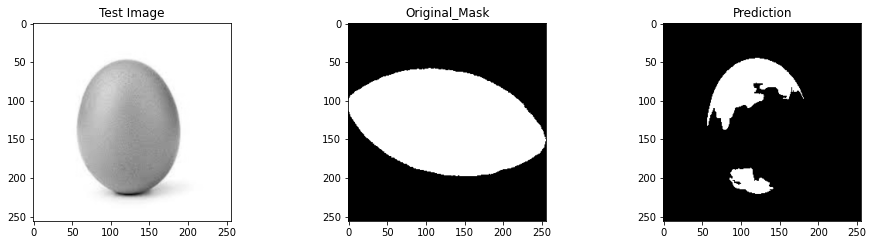

In [ ]:
plt.figure(figsize=(16,8))
test_image=np.resize(test_image,(256,256,1))
original_mask=np.resize(original_mask,(256,256,1))
prediction=np.resize(prediction,(256,256,1))
# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------
plt.subplot(231)
plt.title("Test Image")
plt.imshow(test_image[:,:,0],cmap="gray")
# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------
plt.subplot(232)
plt.title("Original_Mask")
plt.imshow(original_mask[:,:,0],cmap="gray")
# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------
plt.subplot(233)
plt.title("Prediction")
plt.imshow(prediction[:,:,0],cmap="gray")
# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------

In [ ]:
test=cv2.imread("/content/drive/MyDrive/Augmented/Test_Images/4_0_4958.jpeg")
test=np.resize(test,(256,256,3))

# ground_truth=cv2.imread("/content/drive/MyDrive/Augmented/Test_Masks/4_0_4958.jpeg")
# ground_truth=np.resize(ground_truth, (168, 300, 1))

test=np.expand_dims(test,0)
prediction=model.predict(test)
prediction=prediction>0.5
prediction=np.resize(prediction,(168,168,3))
# prediction=(prediction)
plt.imshow(prediction)
# test_img_input.shape

In [ ]:
def generator(images, masks):      
  train_generator = zip(images, masks)
  for (images, masks) in train_generator:
    yield (images, masks)

In [ ]:
# !pip install segmentation_models
import segmentation_models as sm
jaccard_loss=sm.losses.bce_jaccard_loss
iou_metrics=[sm.metrics.iou_score]

## Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/logs